# Importing Dependencies

In [43]:
import numpy as np 
import pandas as pd 
import os 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from PIL import Image
import glob
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from PIL import Image
import pickle


# Loading The Data

In [4]:
images = []
mask = glob.glob("/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/*/*_mask.png")
for i in mask:
    images.append(i.replace('_mask',''))

In [5]:
print(images[:5])
print('-------------------')
print(mask[:5])

['/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (166).png', '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (290).png', '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (430).png', '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (89).png', '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (261).png']
-------------------
['/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (166)_mask.png', '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (290)_mask.png', '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (430)_mask.png', '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (89)_mask.png', '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (261)_mask.png']


# Visualising The Data

In [6]:
data = pd.DataFrame({'images':images,'masks':mask})
data.head(9)

images  \
0  /kaggle/input/breast-ultrasound-images-dataset...   
1  /kaggle/input/breast-ultrasound-images-dataset...   
2  /kaggle/input/breast-ultrasound-images-dataset...   
3  /kaggle/input/breast-ultrasound-images-dataset...   
4  /kaggle/input/breast-ultrasound-images-dataset...   
5  /kaggle/input/breast-ultrasound-images-dataset...   
6  /kaggle/input/breast-ultrasound-images-dataset...   
7  /kaggle/input/breast-ultrasound-images-dataset...   
8  /kaggle/input/breast-ultrasound-images-dataset...   

                                               masks  
0  /kaggle/input/breast-ultrasound-images-dataset...  
1  /kaggle/input/breast-ultrasound-images-dataset...  
2  /kaggle/input/breast-ultrasound-images-dataset...  
3  /kaggle/input/breast-ultrasound-images-dataset...  
4  /kaggle/input/breast-ultrasound-images-dataset...  
5  /kaggle/input/breast-ultrasound-images-dataset...  
6  /kaggle/input/breast-ultrasound-images-dataset...  
7  /kaggle/input/breast-ultrasound-images-dataset...  
8  /kaggle/input/breast-ultrasound-images-dataset...

In [7]:
data.shape

(780, 2)

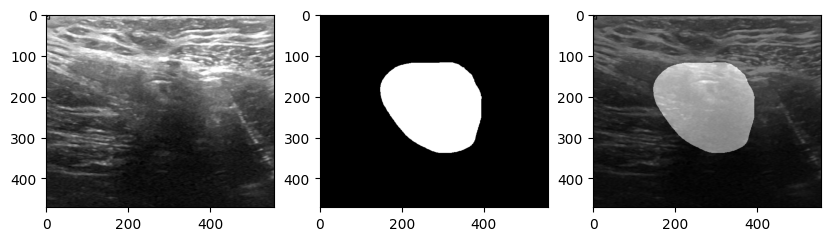

In [8]:
import cv2 
N=5
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
img=cv2.imread(data.images.iloc[N])
plt.imshow(img)
plt.subplot(1,3,2)
msk=cv2.imread(data.masks.iloc[N])
plt.imshow(msk)
plt.subplot(1,3,3)
plt.imshow(img)
plt.imshow(msk,alpha=0.5)

# Splitting The Data

In [9]:
data_train,data_test=train_test_split(data,test_size=0.1)

data_train,data_val=train_test_split(data_train,test_size=0.1)

In [10]:
datagen = ImageDataGenerator(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest',
                            rescale=1./255)

In [11]:
image_train=datagen.flow_from_dataframe(data_train,  
                                    target_size=(256,256), 
                                    color_mode='rgb',
                                    shuffle=True,
                                    seed=42,
                                    x_col ="images", 
                                    batch_size=32,
                                    class_mode=None
                                    
)
mask_train=datagen.flow_from_dataframe(data_train, 
                                    target_size=(256,256), 
                                    color_mode='grayscale',
                                    shuffle=True,
                                    seed=42,
                                    x_col ="masks", 
                                    batch_size=32,
                                    class_mode=None
)

Found 631 validated image filenames.
Found 631 validated image filenames.


In [12]:
image_validation=datagen.flow_from_dataframe(data_val,  
                                    target_size=(256,256), 
                                    color_mode='rgb',
                                    shuffle=True,
                                    seed=42,
                                    x_col ="images", 
                                    batch_size=32,
                                    class_mode=None
)

mask_validation=datagen.flow_from_dataframe(data_val, 
                                    target_size=(256,256), 
                                    color_mode='grayscale',
                                    shuffle=True,
                                    seed=42,
                                    x_col ="masks", 
                                    batch_size=32,
                                    class_mode=None
)

Found 71 validated image filenames.
Found 71 validated image filenames.


# Creating The Model

In [14]:
def unet(input_size=(256,256,3)):
    inputs = layers.Input(input_size)
    
    conv1 = layers.Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = layers.Activation('relu')(conv1)
    conv1 = layers.Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = layers.BatchNormalization(axis=3)(conv1)
    bn1 = layers.Activation('relu')(bn1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = layers.Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = layers.Activation('relu')(conv2)
    conv2 = layers.Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = layers.BatchNormalization(axis=3)(conv2)
    bn2 = layers.Activation('relu')(bn2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = layers.Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = layers.Activation('relu')(conv3)
    conv3 = layers.Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = layers.BatchNormalization(axis=3)(conv3)
    bn3 = layers.Activation('relu')(bn3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = layers.Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = layers.Activation('relu')(conv4)
    conv4 = layers.Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = layers.BatchNormalization(axis=3)(conv4)
    bn4 = layers.Activation('relu')(bn4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = layers.Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = layers.Activation('relu')(conv5)
    conv5 = layers.Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = layers.BatchNormalization(axis=3)(conv5)
    bn5 = layers.Activation('relu')(bn5)

    up6 = layers.concatenate([layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = layers.Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = layers.Activation('relu')(conv6)
    conv6 = layers.Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = layers.BatchNormalization(axis=3)(conv6)
    bn6 = layers.Activation('relu')(bn6)

    up7 = layers.concatenate([layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = layers.Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = layers.Activation('relu')(conv7)
    conv7 = layers.Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = layers.BatchNormalization(axis=3)(conv7)
    bn7 = layers.Activation('relu')(bn7)

    up8 = layers.concatenate([layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = layers.Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = layers.Activation('relu')(conv8)
    conv8 = layers.Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = layers.BatchNormalization(axis=3)(conv8)
    bn8 = layers.Activation('relu')(bn8)

    up9 = layers.concatenate([layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = layers.Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = layers.Activation('relu')(conv9)
    conv9 = layers.Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = layers.BatchNormalization(axis=3)(conv9)
    bn9 = layers.Activation('relu')(bn9)

    conv10 = layers.Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return models.Model(inputs=[inputs], outputs=[conv10])

In [15]:
smooth=1
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

In [17]:
model = unet(input_size=(256, 256,3))

In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 activation_18 (Activation)     (None, 256, 256, 64  0           ['conv2d_19[0][0]']              
                                )                                                           

In [20]:
model.compile(
    optimizer='adam',
    loss=bce_dice_loss,
    metrics=[dice_coef,'accuracy'])

In [21]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=50,
    validation_steps=len(data_val) /32,
    steps_per_epoch=len(data_train) /32
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


19/19 [==============================] - 113s 4s/step - loss: 1.2455 - dice_coef: 0.1577 - accuracy: 0.8619 - val_loss: 14.0167 - val_dice_coef: 0.0897 - val_accuracy: 0.1081
Epoch 2/50
19/19 [==============================] - 40s 2s/step - loss: 1.0077 - dice_coef: 0.2733 - accuracy: 0.8934 - val_loss: 64.9986 - val_dice_coef: 0.1174 - val_accuracy: 0.0734
Epoch 3/50
19/19 [==============================] - 41s 2s/step - loss: 0.8989 - dice_coef: 0.3435 - accuracy: 0.9117 - val_loss: 12.0837 - val_dice_coef: 0.1010 - val_accuracy: 0.1538
Epoch 4/50
19/19 [==============================] - 38s 2s/step - loss: 0.8155 - dice_coef: 0.4092 - accuracy: 0.9216 - val_loss: 10.0961 - val_dice_coef: 0.1414 - val_accuracy: 0.2474
Epoch 5/50
19/19 [==============================] - 41s 2s/step - loss: 0.7549 - dice_coef: 0.4522 - accuracy: 0.9258 - val_loss: 1.8472 - val_dice_coef: 0.2628 - val_accuracy: 0.5939
Epoch 6/50
19/19 [==============================] - 39s 2s/step - loss: 0.6890 - dice_

In [24]:
eval_results = model.evaluate(valid_gen, steps=len(data_val) /32, verbose=1)

2/2 [==============================] - 2s 1s/step - loss: 0.5115 - dice_coef: 0.6442 - accuracy: 0.9532       


# Making Predictions

1/1 [==============================] - 0s 28ms/step


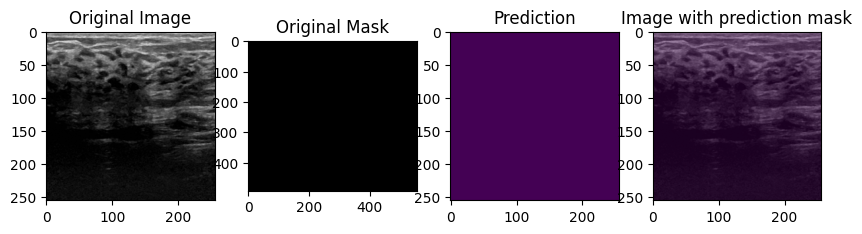

1/1 [==============================] - 0s 26ms/step


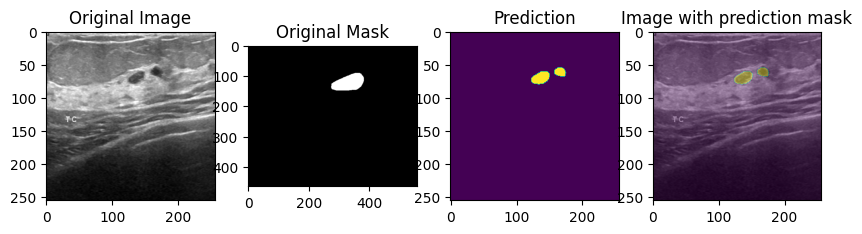

1/1 [==============================] - 0s 26ms/step


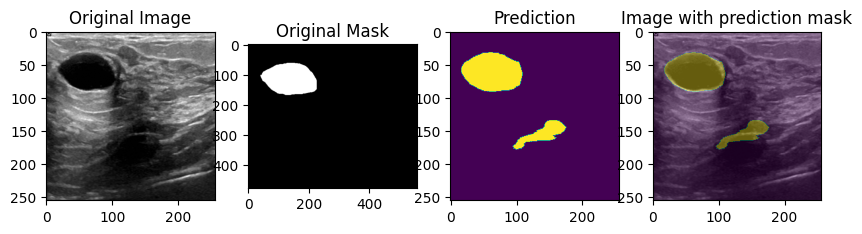

1/1 [==============================] - 0s 27ms/step


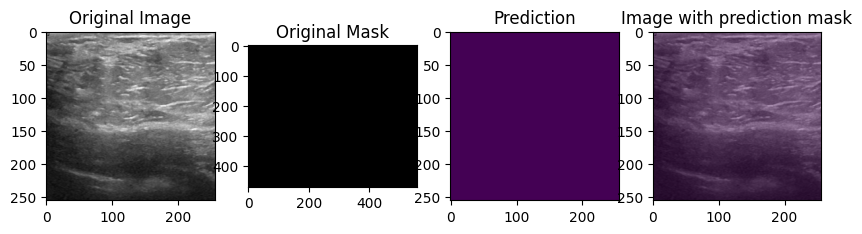

1/1 [==============================] - 0s 25ms/step


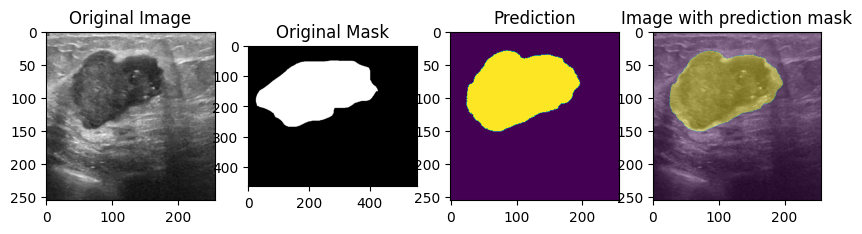

1/1 [==============================] - 0s 27ms/step


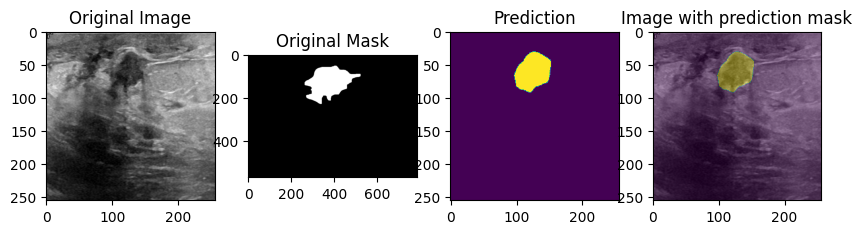

1/1 [==============================] - 0s 25ms/step


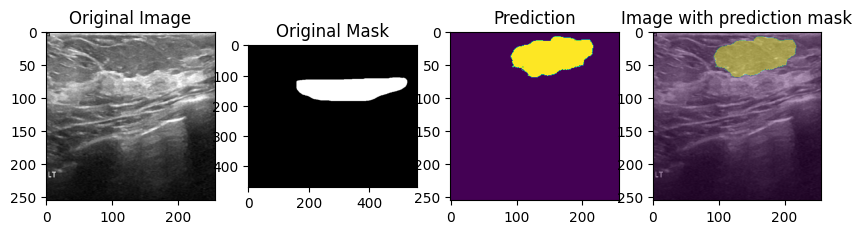

1/1 [==============================] - 0s 33ms/step


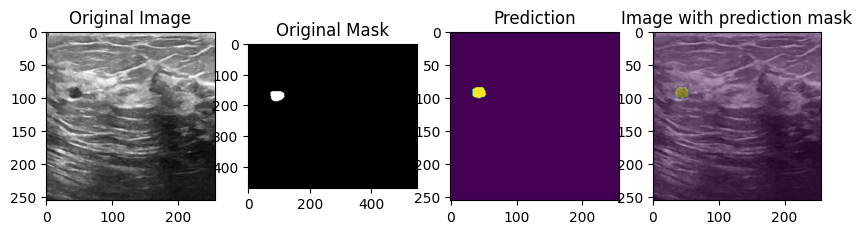

1/1 [==============================] - 0s 25ms/step


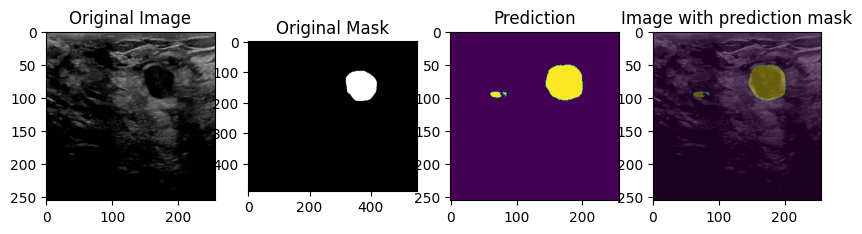

1/1 [==============================] - 0s 25ms/step


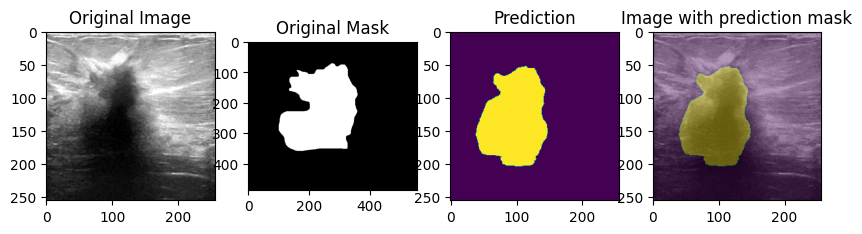

1/1 [==============================] - 0s 26ms/step


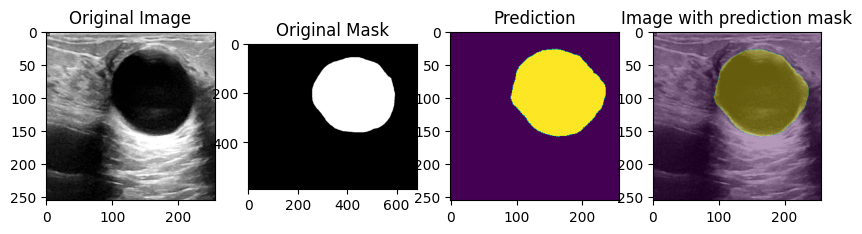

1/1 [==============================] - 0s 25ms/step


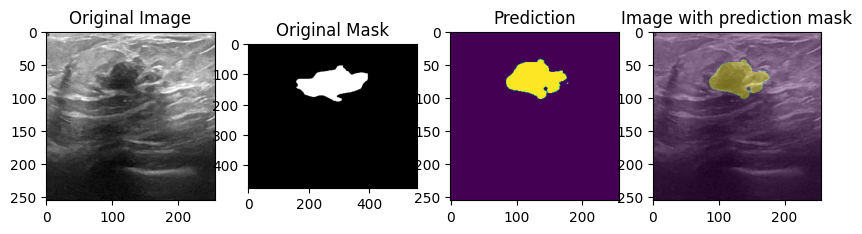

1/1 [==============================] - 0s 26ms/step


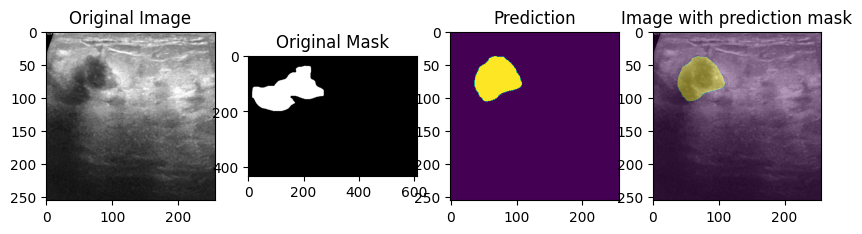

1/1 [==============================] - 0s 27ms/step


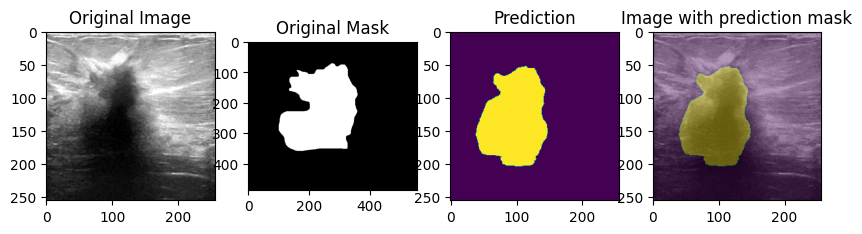

1/1 [==============================] - 0s 24ms/step


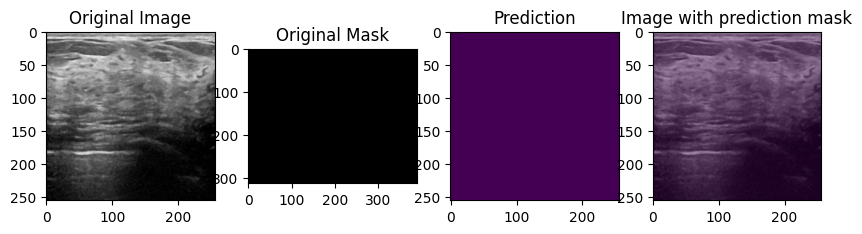

1/1 [==============================] - 0s 26ms/step


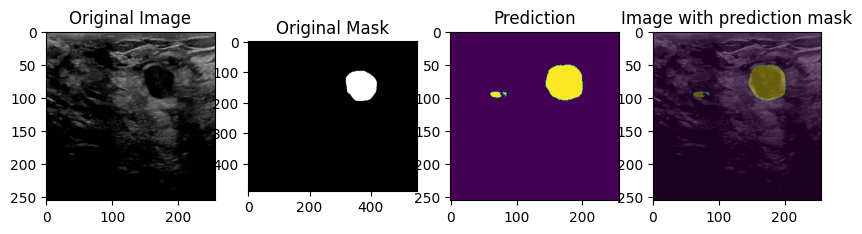

1/1 [==============================] - 0s 27ms/step


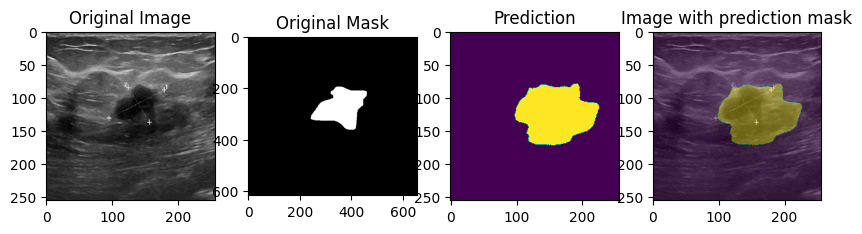

1/1 [==============================] - 0s 38ms/step


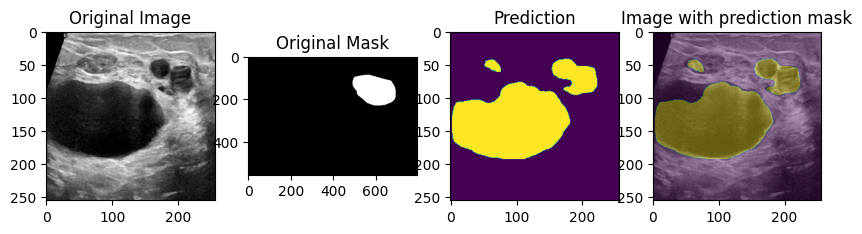

1/1 [==============================] - 0s 28ms/step


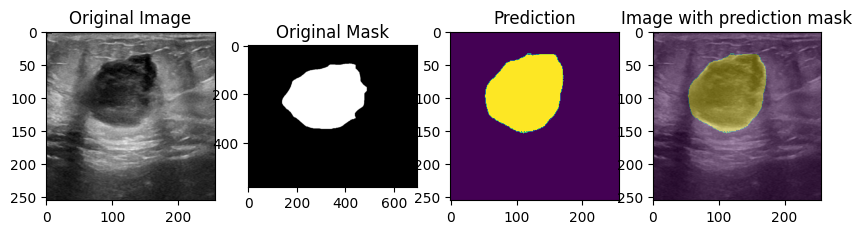

1/1 [==============================] - 0s 37ms/step


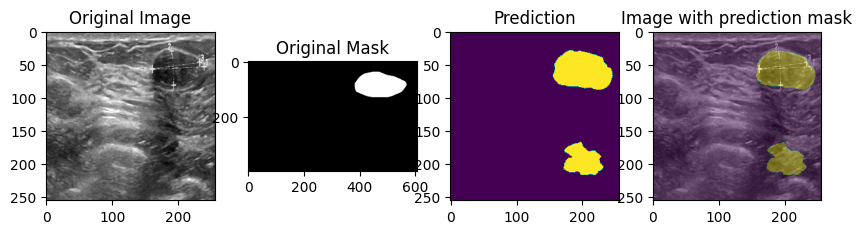

1/1 [==============================] - 0s 26ms/step


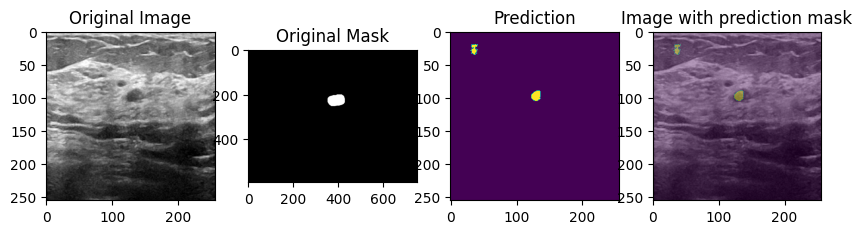

1/1 [==============================] - 0s 24ms/step


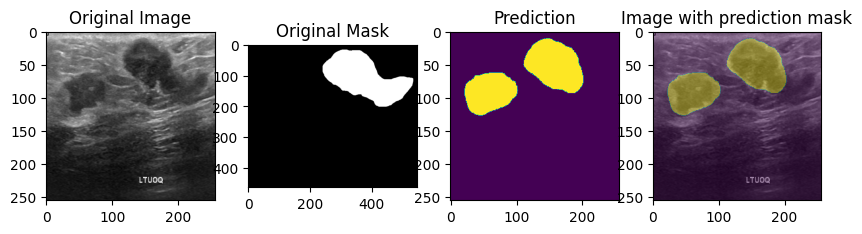

1/1 [==============================] - 0s 25ms/step


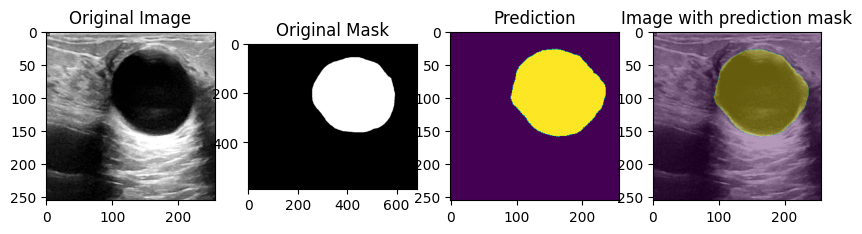

1/1 [==============================] - 0s 26ms/step


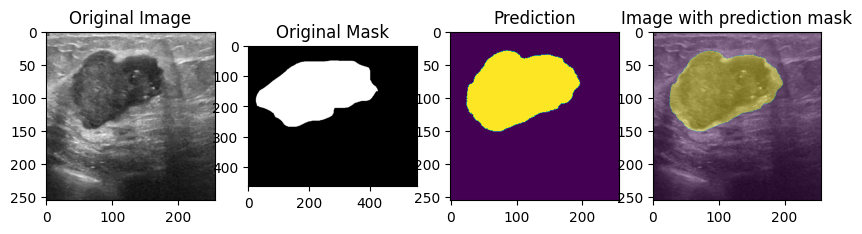

1/1 [==============================] - 0s 24ms/step


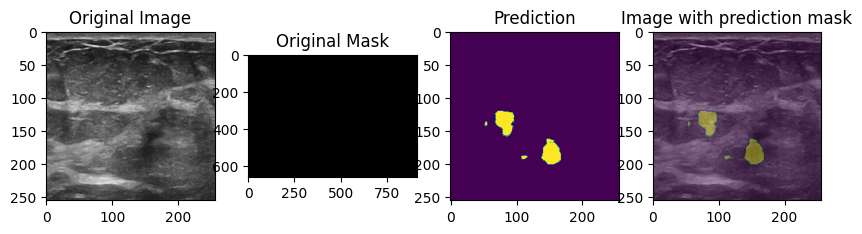

1/1 [==============================] - 0s 26ms/step


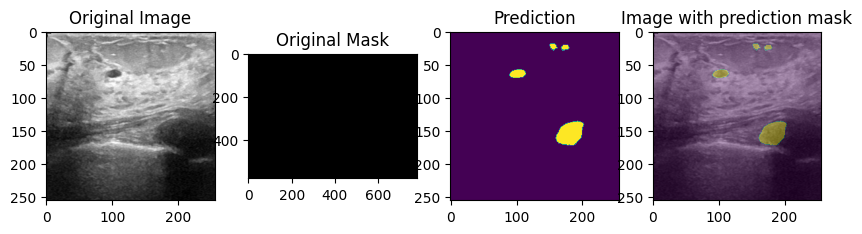

1/1 [==============================] - 0s 25ms/step


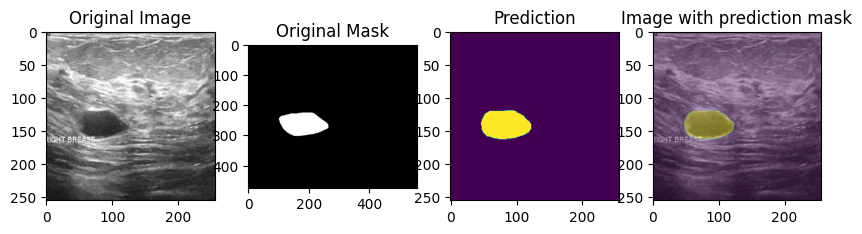

1/1 [==============================] - 0s 25ms/step


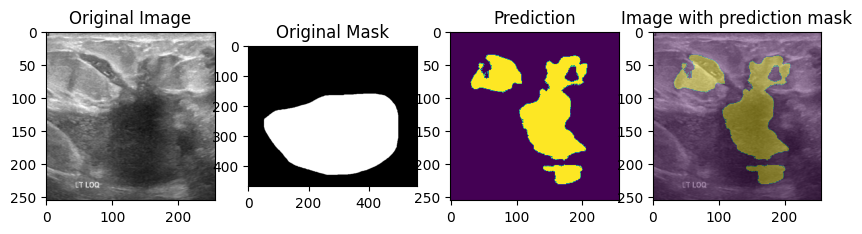

1/1 [==============================] - 0s 25ms/step


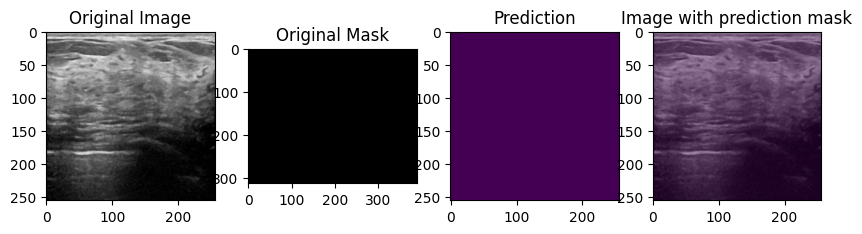

1/1 [==============================] - 0s 27ms/step


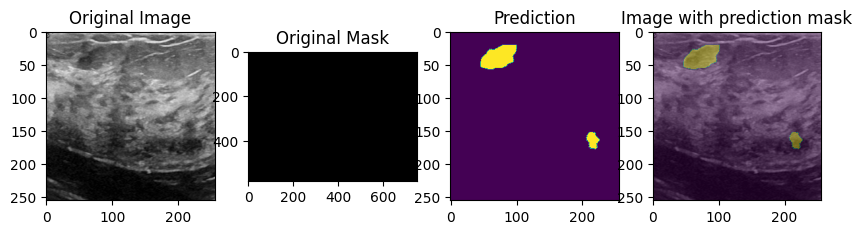

In [29]:
import cv2
for i in range(30):
    index=np.random.randint(1,len(data_test.index))
    img = cv2.imread(data_test['images'].iloc[index])
    img = cv2.resize(img ,(256, 256))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(10,10))
    plt.subplot(1,4,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,4,2)
    plt.imshow(np.squeeze(cv2.imread(data_test['masks'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,4,3)
    plt.imshow(np.squeeze(pred) > .8)
    plt.title('Prediction')
    plt.subplot(1,4,4)
    plt.imshow(np.squeeze(img))
    plt.imshow(np.squeeze(pred) > .8,alpha=0.4)
    plt.title('Image with prediction mask')
    plt.show()

In [44]:
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_10
.........vars
......activation_11
.........vars
......activation_12
.........vars
......activation_13
.........vars
......activation_14
.........vars
......activation_15
.........vars
......activation_16
.........vars
......activation_17
.........vars
......activation_2
.........vars
......activation_3
.........vars
......activation_4
.........vars
......activation_5
.........vars
......activation_6
.........vars
......activation_7
.........vars
......activation_8
.........vars
......activation_9
.........vars
......batch_normalization
.........vars
............0
............1
............2
............3
......batch_normalization_1
.........vars
............0
............1
............2
............3
......batch_normalization_2
.........vars
............0
............1
............2
............3
......batch_normalization_3
....